# Evaluate the cross validation of different mass balance hyper parameters
The data file is produced by the VAS adapted cross validation module (https://github.com/oberrauch/mb_crossval) originally from Matze (https://github.com/OGGM/mb_crossval).

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# read dictionary
path = '/Users/oberrauch/mb_crossval/data/xval/xval_1.1.2.dev44+gf9ab669-histalp_major.p'
xvaldict = pickle.load(open(path, "rb"))

In [6]:
# get dataframe
stats = xvaldict['statistic']
# remove temperature gradient, since it is constant (-0.0065 K/m)
stats = stats.drop('tgrad', axis=1)
stats.head()

,prcpsf,tliq,tmelt,std_quot,bias,rmse,core,std_oggm,std_ref,nans
0,1.5,1,-2,0.53561,54.5083,276.3,0.630709,353.762,660.483,0
1,1.5,1,-1.75,0.547653,36.1525,283.222,0.632451,361.715,660.483,0
2,1.5,1,-1.5,0.556322,36.3591,280.444,0.634298,367.441,660.483,0
3,1.5,1,-1.25,0.564546,34.8341,278.638,0.635844,372.873,660.483,0
4,1.5,1,-1,0.578597,19.5265,272.345,0.637201,382.154,660.483,0


**Compute scores for the statistical measures**

Text(0, 0.5, 'Bias score')

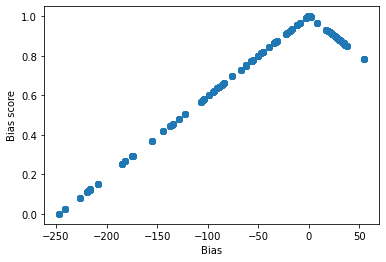

In [29]:
stats['bias_score'] = (stats.bias.max() - abs(stats.bias))
stats['bias_score'] /=  (stats.bias_score.max() - stats.bias_score.min())
stats['bias_score'] -= stats.bias_score.min()
plt.scatter(stats.bias, stats.bias_score)
plt.xlabel('Bias')
plt.ylabel('Bias score')

Text(0, 0.5, 'Correlation score')

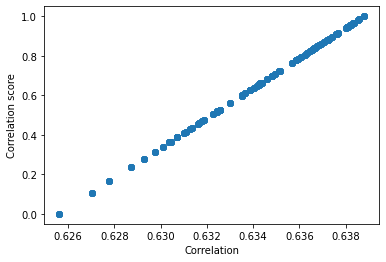

In [26]:
stats['core_score'] = (abs(stats.core) - stats.core.min())/(stats.core.max() - stats.core.min())
plt.scatter(stats.core, stats.core_score)
plt.xlabel('Correlation')
plt.ylabel('Correlation score')

Text(0, 0.5, 'Standard deviation score')

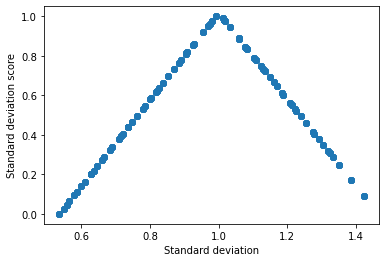

In [31]:
stats['std_quot_score'] = (stats.std_quot.max() - abs(stats.std_quot - 1))
stats['std_quot_score'] /= (stats.std_quot_score.max() - stats.std_quot_score.min())
stats['std_quot_score'] -= stats.std_quot_score.min()
plt.scatter(stats.std_quot, stats.std_quot_score)
plt.xlabel('Standard deviation')
plt.ylabel('Standard deviation score')

Text(0, 0.5, 'RMSE score')

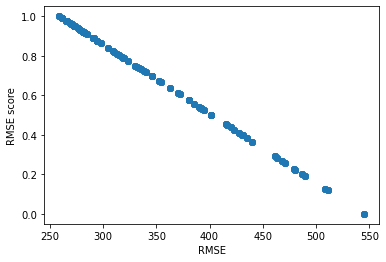

In [7]:
stats['rmse_score'] = (stats.rmse.max() - stats.rmse)/(stats.rmse.max() - stats.rmse.min())
plt.scatter(stats.rmse, stats.rmse_score)
plt.xlabel('RMSE')
plt.ylabel('RMSE score')

The scores have different ranges, the highest number are found for the standard deviation score and the lowest for the bias score. Hence, the former has the highest weight and the latter the lowest. That seems odd...

**Compute overall score as sum of individual scores**, whereby higher values indicate better performance

In [32]:
stats['score'] = stats.std_quot_score + stats.bias_score + stats.core_score
stats.sort_values('score', ascending=False).head(10)

,prcpsf,tliq,tmelt,std_quot,bias,rmse,core,std_oggm,std_ref,nans,bias_score,std_quot_score,core_score,score
186,2.5,1,-0.5,0.981936,-57.0364,354.49,0.638179,648.552,660.483,0,0.771087,0.978437,0.954412,2.70394
195,2.5,1.5,-0.5,0.981936,-57.0364,354.49,0.638179,648.552,660.483,0,0.771087,0.978437,0.954412,2.70394
204,2.5,2,-0.5,0.981936,-57.0364,354.49,0.638179,648.552,660.483,0,0.771087,0.978437,0.954412,2.70394
213,2.5,2.5,-0.5,0.981936,-57.0364,354.49,0.638179,648.552,660.483,0,0.771087,0.978437,0.954412,2.70394
222,2.5,3,-0.5,0.981936,-57.0364,354.49,0.638179,648.552,660.483,0,0.771087,0.978437,0.954412,2.70394
224,2.5,3,0,1.01717,-50.3691,385.694,0.636525,671.821,660.483,0,0.79819,0.980407,0.828658,2.60726
188,2.5,1,0,1.01717,-50.3691,385.694,0.636525,671.821,660.483,0,0.79819,0.980407,0.828658,2.60726
197,2.5,1.5,0,1.01717,-50.3691,385.694,0.636525,671.821,660.483,0,0.79819,0.980407,0.828658,2.60726
206,2.5,2,0,1.01717,-50.3691,385.694,0.636525,671.821,660.483,0,0.79819,0.980407,0.828658,2.60726
215,2.5,2.5,0,1.01717,-50.3691,385.694,0.636525,671.821,660.483,0,0.79819,0.980407,0.828658,2.60726


All of the ten highest scores result from using a **precipiation scaling factor of 2.5**, and the five highest scores result from additionally using a **temperature threshold for melting of -0.5 degC**. The temperature threshold for liwuid precipitation seems to have no effect...

**Confirm findings graphically**

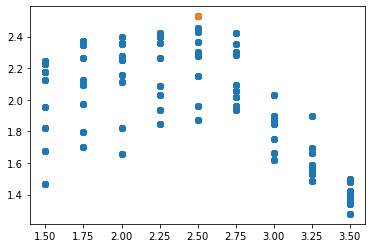

In [9]:
# plot score as function of precipitation scaling factor
plt.scatter(stats.prcpsf, stats.score)
plt.scatter(stats.prcpsf.where(stats.score == stats.score.max()).dropna().iloc[0], stats.score.max())

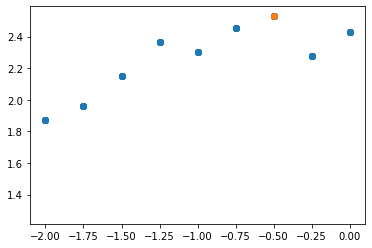

In [10]:
# subset for precipitation scaling factor of 2.5 and
# plot score as function of temperature threshold for melt
plt.scatter(stats.where(stats.prcpsf == 2.5).tmelt, stats.score)
plt.scatter(stats.tmelt.where(stats.score == stats.score.max()).dropna().iloc[0], stats.score.max())

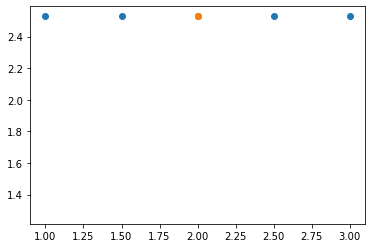

In [11]:
# subset for precipitation scaling factor of 2.5 and 
# temperature threshold for melt of -0.5 degC and
# plot score as function of temperature threshold for liquid precipitations
plt.scatter(stats.where((stats.prcpsf == 2.5) & (stats.tmelt == -0.5)).tliq, stats.score)
plt.scatter(stats.tliq.where(stats.score == stats.score.max()).dropna().iloc[2], stats.score.max())